In [1]:
# Import Libraries

import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load and Display the Image

image_path = "./data/joints.png"

# Load image using OpenCV (as BGR)
img_bgr = cv2.imread(image_path)
if img_bgr is None:
    raise FileNotFoundError(f"Image '{image_path}' not found")

# Convert to RGB for matplotlib display
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

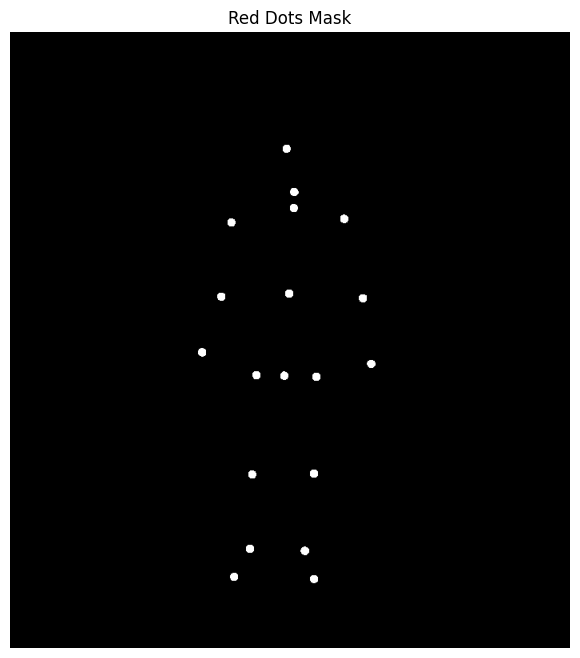

In [3]:
# Threshold for Red Dots in the Image

# Convert BGR to HSV
img_hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)

# Define red color range in HSV (two ranges because red wraps around)
lower_red1 = np.array([0, 200, 200])
upper_red1 = np.array([5, 255, 255])
lower_red2 = np.array([175, 200, 200])
upper_red2 = np.array([180, 255, 255])

# Create masks for the two red ranges and combine
mask1 = cv2.inRange(img_hsv, lower_red1, upper_red1)
mask2 = cv2.inRange(img_hsv, lower_red2, upper_red2)
red_mask = cv2.bitwise_or(mask1, mask2)

# Optional: Clean up small noise with morphological operations
kernel = np.ones((3, 3), np.uint8)
red_mask_clean = cv2.morphologyEx(red_mask, cv2.MORPH_OPEN, kernel)

# Show the mask
plt.figure(figsize=(8, 8))
plt.imshow(red_mask_clean, cmap='gray')
plt.title("Red Dots Mask")
plt.axis('off')
plt.show()

In [4]:
# Find Contours of Red Dots

# Find contours in the mask
contours, _ = cv2.findContours(red_mask_clean, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

dot_centers = []
min_area = 10  # Minimum area to filter out noise

for contour in contours:
    area = cv2.contourArea(contour)
    if area > min_area:
        M = cv2.moments(contour)
        if M["m00"] > 0:
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
            dot_centers.append((cx, cy))

print(f"Found {len(dot_centers)} red dots.")

Found 19 red dots.


In [5]:
# Sort and Number the Dots

# Sort by y, then x for consistency
dot_centers_sorted = sorted(dot_centers, key=lambda p: (p[1], p[0]))

# Display the sorted coordinates
for idx, (x, y) in enumerate(dot_centers_sorted):
    print(f"Dot {idx}: (x={x}, y={y})")

Dot 0: (x=345, y=145)
Dot 1: (x=354, y=199)
Dot 2: (x=354, y=219)
Dot 3: (x=417, y=233)
Dot 4: (x=276, y=237)
Dot 5: (x=348, y=326)
Dot 6: (x=263, y=330)
Dot 7: (x=440, y=332)
Dot 8: (x=239, y=399)
Dot 9: (x=451, y=414)
Dot 10: (x=307, y=428)
Dot 11: (x=342, y=429)
Dot 12: (x=382, y=430)
Dot 13: (x=379, y=551)
Dot 14: (x=302, y=552)
Dot 15: (x=299, y=645)
Dot 16: (x=368, y=648)
Dot 17: (x=279, y=680)
Dot 18: (x=379, y=683)


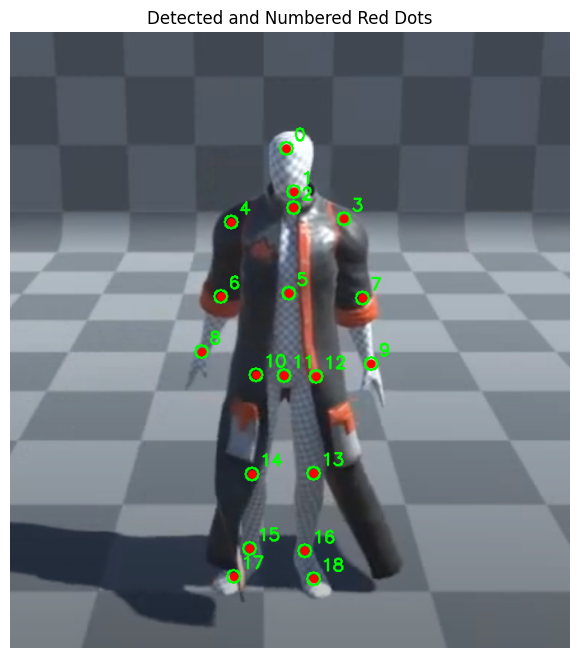

In [6]:
# Visualize the Numbered Dots on the Image

# Copy image for drawing
img_out = img_rgb.copy()

# Draw green circles and numbers
for idx, (x, y) in enumerate(dot_centers_sorted):
    cv2.circle(img_out, (x, y), 8, (0, 255, 0), 2)
    cv2.putText(img_out, str(idx), (x+10, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0), 2)

# Show the result
plt.figure(figsize=(8, 8))
plt.imshow(img_out)
plt.title("Detected and Numbered Red Dots")
plt.axis('off')
plt.show()

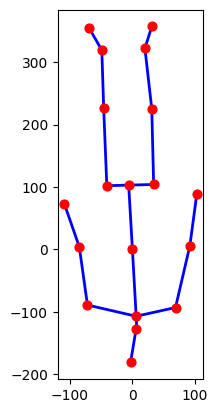

In [11]:
# Manually label the dots according to their anatomical joint type

from skeleton import Skeleton

jt = Skeleton.JointType

# Manually define the joint types for each dot based on the sorted order
dot_labels: list[Skeleton.JointType] = [
    # head and neck
    jt.HEAD,
    jt.NECK,
    jt.TORSO_UP,

    # shoulders, elbows, wrists
    jt.SHOULDER_LEFT,
    jt.SHOULDER_RIGHT,
    jt.TORSO_MID,
    jt.ELBOW_RIGHT,
    jt.ELBOW_LEFT,
    jt.WRIST_RIGHT,
    jt.WRIST_LEFT,

    # hips, knees, ankles, feet
    jt.HIP_RIGHT,      # 9
    jt.TORSO_DOWN,
    jt.HIP_LEFT,       #10
    jt.KNEE_LEFT,      #14
    jt.KNEE_RIGHT,     #13
    jt.ANKLE_RIGHT,    #16
    jt.ANKLE_LEFT,     #15
    jt.FEET_RIGHT,     #18
    jt.FEET_LEFT,      #17
]

# Create the dictionary mapping between joint types and their coordinates
assert len(dot_centers_sorted) == len(dot_labels), "Number of dots and labels must match"

joint_coordinates = dict()
for joint_type, coords in zip(dot_labels, dot_centers_sorted):
    joint_coordinates[joint_type] = coords

# Now we can draw the skeleton
ske = Skeleton(joint_coordinates)
ske.draw()